In [1]:
import os
# Importing the libraries
import numpy as np
import pandas as pd
import math
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from matplotlib import pyplot
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [2]:
def labelToOneHot(label):# 0 --> [1 0], 1--> [0 1]
    label = label.reshape(len(label), 1)
    label = np.append(label, label, axis = 1)
    label[:,0] = label[:,0] == 0;
    return label

In [3]:
def classificationPerformanceByThreshold(threshold, y_pred, y_test):
    """
    # Making the Confusion Matrix
    cm = confusion_matrix(y_test, Y_pred)
    print("some y_pred ",Y_pred[:5])
    tn, fp, fn, tp = cm.ravel()
    """
    y_test = labelToOneHot(y_test)
    auc=roc_auc_score(y_test, y_pred)
    y_test = np.argmax(y_test, axis = 1)
    
    
    Y_pred = np.empty_like(y_pred)
    for i in range(len(y_pred)):
        if y_pred[i][0]>=threshold:
            Y_pred[i]=np.array([1,0]) #assign as class pos
        else:
            Y_pred[i]=np.array([0,1]) #assign as class neg
    
    Y_pred = np.argmax(Y_pred, axis = 1)
    
    
    cm = confusion_matrix(y_test, Y_pred, labels = [0,1])
   
    tn=cm[0][0]
    fn=cm[1][0]
    tp=cm[1][1]
    fp=cm[0][1]
    
    if float(tp)+float(fn)==0:
        TPR=round(float(tp)/0.00000001,3)
    else:
        TPR=round(float(tp)/(float(tp)+float(fn)),3)
    
    if float(fp)+float(tn)==0:
        FPR=round(float(fp)/(0.00000001),3)
    else:
        FPR=round(float(fp)/(float(fp)+float(tn)),3)
    
    if float(tp) + float(fp) + float(fn) + float(tn)==0:
        accuracy = round((float(tp) + float(tn))/(0.00000001),3)    
    else:
        accuracy = round((float(tp) + float(tn))/(float(tp) + float(fp) + float(fn) + float(tn)),3)
        
    if float(tn) + float(fp)==0:
        specitivity=round(float(tn)/(0.00000001),3)
    else:
        specitivity=round(float(tn)/(float(tn) + float(fp)),3)
        
    if float(tp) + float(fn)==0:
        sensitivity = round(float(tp)/(0.00000001),3)
    else:
        sensitivity = round(float(tp)/(float(tp) + float(fn)),3)
    
    if float(tp) + float(fp)==0:
        precision = round(float(tp)/(0.00000001),3)
    else:
        precision = round(float(tp)/(float(tp) + float(fp)),3)
    
    if math.sqrt((float(tp)+float(fp))*(float(tp)+float(fn))*(float(tn)+float(fp))*(float(tn)+float(fn)))==0:
        mcc = round((float(tp)*float(tn) - float(fp)*float(fn))/0.00000001,3)
    else:
        mcc = round((float(tp)*float(tn) - float(fp)*float(fn))/math.sqrt(
                                                                    (float(tp)+float(fp))
                                                                    *(float(tp)+float(fn))
                                                                    *(float(tn)+float(fp))
                                                                    *(float(tn)+float(fn))
                                                                    ),3)
    balAcc=(sensitivity+specitivity)/2
    if (sensitivity+precision)==0:
        f_measure = round(2*sensitivity*precision/(0.00000001),3)
    else:
        f_measure = round(2*sensitivity*precision/(sensitivity+precision),3)
    
    return accuracy, specitivity, sensitivity, mcc, tp, tn, fp, fn, TPR, FPR, balAcc, precision, f_measure, auc

In [4]:
def runForY_pred(c,g,train_file, test_file):
    # Importing the dataset
    print("Start SVM runForY_pred")
    print(train_file," is processing")
    dataset = pd.read_csv(train_file, header=None)
    X_train = dataset.iloc[:, 0:-1].values
    y_train = dataset.iloc[:, -1].values
    print("\nTraining file X shape ",X_train.shape," Y shape ",y_train.shape)
    
    
    print(test_file," is processing")
    dataset = pd.read_csv(test_file, header=None)
    X_test = dataset.iloc[:, 0:-1].values
    y_test = dataset.iloc[:, -1].values
    print("\nTesting file X shape ",X_test.shape," Y shape ",y_test.shape)
    

    # Fitting Kernel SVM to the Training set
    classifier = SVC(C=c, gamma=g, kernel = 'rbf', random_state = 0, probability=True)
    classifier.fit(X_train, y_train)
    print(" model.classes_ ",classifier.classes_)
    # joblib.dump(classifier, cla+'.pickle_model.pkl', protocol=2)

    # Predicting the Test set results
    y_pred = classifier.predict_proba(X_test)
    y_hat = classifier.predict(X_test)
    
    print("Finish SVM runForY_pred")
    
    return y_test, y_hat, y_pred

In [5]:
def run(c,g,train_file, test_file,result_file):
    # Importing the dataset
    print(train_file," is processing")
    dataset = pd.read_csv(train_file, header=None)
    X_train = dataset.iloc[:, 0:-1].values
    y_train = dataset.iloc[:, -1].values
    print("\nTraining file X shape ",X_train.shape," Y shape ",y_train.shape)
    
    
    print(test_file," is processing")
    dataset = pd.read_csv(test_file, header=None)
    X_test = dataset.iloc[:, 0:-1].values
    y_test = dataset.iloc[:, -1].values
    print("\nTesting file X shape ",X_test.shape," Y shape ",y_test.shape)
    

    # Fitting Kernel SVM to the Training set
    classifier = SVC(C=c, gamma=g, kernel = 'rbf', random_state = 0, probability=True)
    classifier.fit(X_train, y_train)
    print(" model.classes_ ",classifier.classes_)
    # joblib.dump(classifier, cla+'.pickle_model.pkl', protocol=2)

    # Predicting the Test set results
    y_pred = classifier.predict_proba(X_test)
    
    
    f2=open(result_file,"a")
    f2.write("Threshold ,Aaccuracy ,Specitivity ,Sensitivity ,MCC ,Precision ,tp ,tn ,fp ,fn ,TPR ,FPR ,balAcc ,precision , f_measure ,AUC\n")
    threshold=0.01
    while threshold<1.01:
        accuracy, specitivity, sensitivity, mcc, tp, tn, fp, fn, TPR, FPR, balAcc, precision, f_measure, auc = classificationPerformanceByThreshold(threshold, y_pred, y_test)
        f2.write(str(threshold)+", "+str(accuracy)+", "+str(specitivity)+", "+str(sensitivity)+", "+str(mcc)+", "+str(precision)+", "+str(tp)+", "+str(tn)+", "+str(fp)+", "+str(fn)+", "+str(TPR)+", "+str(FPR)+", "+str(balAcc)+", "+str(precision)+", "+str(f_measure)+", "+str(auc)+"\n")
        threshold+=0.002
    f2.close()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#!ls "drive/MyDrive/Electron transport - AutoEncoder/FMN/pssm features wd 15"

In [8]:
def runAndPlot(c,g,train_file, test_file,fold, rsFile):
    # Importing the dataset
    print("Start MLP runForY_pred")
    print(train_file," is processing")
    dataset = pd.read_csv(train_file, header=None)
    X_train = dataset.iloc[:, 0:-1].values
    y_train = dataset.iloc[:, -1].values
    print("\nTraining file X shape ",X_train.shape," Y shape ",y_train.shape)
    
    
    print(test_file," is processing")
    dataset = pd.read_csv(test_file, header=None)
    X_test = dataset.iloc[:, 0:-1].values
    y_test = dataset.iloc[:, -1].values
    y_test=labelToOneHot(y_test)
    print("\nTesting file X shape ",X_test.shape," Y shape ",y_test.shape)
    
     
    # Fitting Kernel SVM to the Training set
    classifier = SVC(C=c, gamma=g, kernel = 'rbf', random_state = 0, probability=True)
    classifier.fit(X_train, y_train)
    print(" model.classes_ ",classifier.classes_)
    # joblib.dump(classifier, cla+'.pickle_model.pkl', protocol=2)

    # Predicting the Test set results
    y_pred = classifier.predict_proba(X_test)
    y_hat = classifier.predict(X_test)
    
    # calculate roc curves
    fprs, tprs, _ = roc_curve(y_test[:,1], y_pred[:,1])
    # plot the roc curve for the model
    roc_auc = roc_auc_score(y_test, y_pred)
    pyplot.plot(fprs, tprs, marker='.', label="SVM-AU ROC is {0:.3f}%".format(roc_auc) )
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    pyplot.title(str(fold)+"_c"+str(c)+"g."+str(g))
    #save the plot
    #folderForImage="drive/MyDrive/Electron transport - AutoEncoder/FMN/pssm features wd 15"
    #pyplot.savefig(folderForImage+"/XG"+str(fold)+"_lr"+str(lr)+"_bs"+str(batch_size)+"_regu"+str(regu)+".AUROC.png")
    # show the plot
    pyplot.show()

    # calculate PR roc curve for model
    # precisions, recalls, thresholds  = precision_recall_curve(y_test, pos_probs)
    precisions, recalls, thresholds  = precision_recall_curve(y_test[:,1], y_pred[:,1])
    # calculate the precision-recall auc
    auc_score = auc(recalls, precisions)
    #plot
    pyplot.plot(recalls, precisions, marker='.', label="SVM-AUPR curve is {0:.3f}%".format(auc_score))
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    pyplot.title(str(fold)+"c"+str(c)+"g."+str(g))
    #save to image
    #pyplot.savefig(folderForImage+"/XG"+str(fold)+"_lr"+str(lr)+"_bs"+str(batch_size)+"_regu"+str(regu)+".AUPR.png")
    # show the plot
    pyplot.show()

    f=open(rsFile[:-4]+".PRCurvePlot.csv","w")
    f.write("recalls,precisions\n")
    for i,j in zip(recalls,precisions):
            f.write(str(i)+","+str(j)+"\n")
    f.close()

    f=open(rsFile[:-4]+".ROCCurvePlot.csv","w")
    f.write("tprs,fprs,auc\n")
    for i,j in zip(tprs,fprs):
            f.write(str(i)+","+str(j)+","+str(roc_auc)+"\n")
    f.close()

    return roc_auc, auc_score


Start MLP runForY_pred
drive/MyDrive/Electron transport - AutoEncoder/FAD/pssm features wd 15/input.train.csv  is processing

Training file X shape  (14278, 300)  Y shape  (14278,)
drive/MyDrive/Electron transport - AutoEncoder/FAD/pssm features wd 15/ind.test.csv  is processing

Testing file X shape  (2906, 300)  Y shape  (2906, 2)
 model.classes_  [0 1]


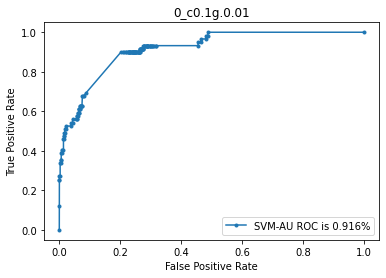

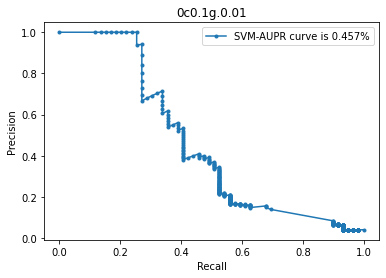

Start MLP runForY_pred
drive/MyDrive/Electron transport - AutoEncoder/FAD/pssm features wd 15/input.fold.train1.csv  is processing

Training file X shape  (11422, 300)  Y shape  (11422,)
drive/MyDrive/Electron transport - AutoEncoder/FAD/pssm features wd 15/input.fold.test1.csv  is processing

Testing file X shape  (2856, 300)  Y shape  (2856, 2)


In [ ]:
bindingTypes=["FAD"]
wd=15

for bindingType in bindingTypes:
      path="drive/MyDrive/Electron transport - AutoEncoder/"+bindingType+"/pssm features wd 15"
      
      # for c in [0.001]:
      #    for g in [0.001]:
      #             for time in range(10):
      #               f=open(path+"/SVM/best/SVM.Overall.Best.Results.csv","a")
      #               rsFile=path+"/SVM/best/time"+str(time)+".c"+str(c)+"g."+str(g)+".ind.csv"
      #               roc_auc, auc_score= runAndPlot( c, g, path+"/input.train.csv", path+"/ind.test.csv",0,rsFile)
      #               f.write("time"+str(time)+",c"+str(c)+"g."+str(g)+".ind,")
      #               f.write(str(roc_auc)+","+str(auc_score)+"\n")
      #               for fold in [1,2,3,4,5]:
      #                 rsFile=path+"/SVM/best/time"+str(time)+".c"+str(c)+"g."+str(g)+".fold"+str(fold)+".csv"
      #                 roc_auc, auc_score=runAndPlot(c,g, path+"/input.fold.train"+str(fold)+".csv", path+"/input.fold.test"+str(fold)+".csv", fold,rsFile)
      #                 f.write("time"+str(time)+",c"+str(c)+"g."+str(g)+".fold"+str(fold)+",")
      #                 f.write(str(roc_auc)+","+str(auc_score)+"\n")
      #               f.close()

      # for c in [0.01]:
      #    for g in [0.001]:
      #             for time in range(10):
      #               f=open(path+"/SVM/best/SVM.Overall.Best.Results.csv","a")
      #               rsFile=path+"/SVM/best/time"+str(time)+".c"+str(c)+"g."+str(g)+".ind.csv"
      #               roc_auc, auc_score= runAndPlot( c, g, path+"/input.train.csv", path+"/ind.test.csv",0,rsFile)
      #               f.write("time"+str(time)+",c"+str(c)+"g."+str(g)+".ind,")
      #               f.write(str(roc_auc)+","+str(auc_score)+"\n")
      #               for fold in [1,2,3,4,5]:
      #                 rsFile=path+"/SVM/best/time"+str(time)+".c"+str(c)+"g."+str(g)+".fold"+str(fold)+".csv"
      #                 roc_auc, auc_score=runAndPlot(c,g, path+"/input.fold.train"+str(fold)+".csv", path+"/input.fold.test"+str(fold)+".csv", fold,rsFile)
      #                 f.write("time"+str(time)+",c"+str(c)+"g."+str(g)+".fold"+str(fold)+",")
      #                 f.write(str(roc_auc)+","+str(auc_score)+"\n")
      #               f.close()

      for c in [0.1]:
         for g in [0.01]:
                  for time in range(10):
                    f=open(path+"/SVM/best/SVM.Overall.Best.Results.csv","a")
                    rsFile=path+"/SVM/best/time"+str(time)+".c"+str(c)+"g."+str(g)+".ind.csv"
                    roc_auc, auc_score= runAndPlot( c, g, path+"/input.train.csv", path+"/ind.test.csv",0,rsFile)
                    f.write("time"+str(time)+",c"+str(c)+"g."+str(g)+".ind,")
                    f.write(str(roc_auc)+","+str(auc_score)+"\n")
                    for fold in [1,2,3,4,5]:
                      rsFile=path+"/SVM/best/time"+str(time)+".c"+str(c)+"g."+str(g)+".fold"+str(fold)+".csv"
                      roc_auc, auc_score=runAndPlot(c,g, path+"/input.fold.train"+str(fold)+".csv", path+"/input.fold.test"+str(fold)+".csv", fold,rsFile)
                      f.write("time"+str(time)+",c"+str(c)+"g."+str(g)+".fold"+str(fold)+",")
                      f.write(str(roc_auc)+","+str(auc_score)+"\n")
                    f.close()

bindingTypes=["FMN"]
wd=15

for bindingType in bindingTypes:
      path="drive/MyDrive/Electron transport - AutoEncoder/"+bindingType+"/pssm features wd 15"
      
      for c in [0.01]:
         for g in [0.01, 0.001]:
                  for time in range(10):
                    f=open(path+"/SVM/best/SVM.Overall.Best.Results.csv","a")
                    rsFile=path+"/SVM/best/time"+str(time)+".c"+str(c)+"g."+str(g)+".ind.csv"
                    roc_auc, auc_score= runAndPlot( c, g, path+"/input.train.csv", path+"/ind.test.csv",0,rsFile)
                    f.write("time"+str(time)+",c"+str(c)+"g."+str(g)+".ind,")
                    f.write(str(roc_auc)+","+str(auc_score)+"\n")
                    for fold in [1,2,3,4,5]:
                      rsFile=path+"/SVM/best/time"+str(time)+".c"+str(c)+"g."+str(g)+".fold"+str(fold)+".csv"
                      roc_auc, auc_score=runAndPlot(c,g, path+"/input.fold.train"+str(fold)+".csv", path+"/input.fold.test"+str(fold)+".csv", fold,rsFile)
                      f.write("time"+str(time)+",c"+str(c)+"g."+str(g)+".fold"+str(fold)+",")
                      f.write(str(roc_auc)+","+str(auc_score)+"\n")
                    f.close()